/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


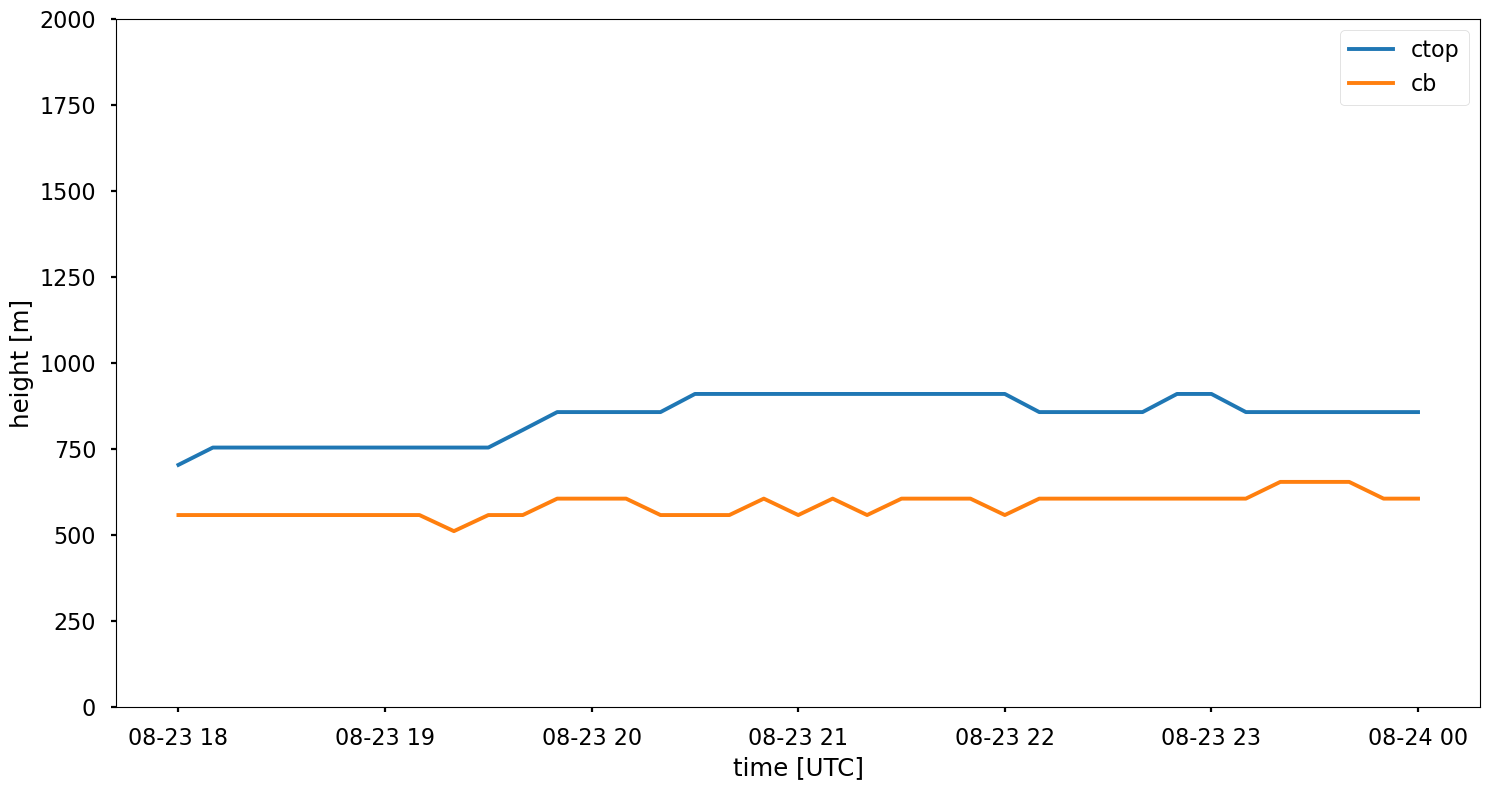

In [1]:
# Ist das Flüssigwasserprofil innerhalb von Wolken in ICON adiabatisch? Verläuft die 
# Zunahme von LWC zwischen cb und ct linear? Wenn nicht, wäre hier eine exakte Abschätzung
# der LWC(z) Werte aus Radardaten in IQQ, statt der Näherung in Cloudnet interessant.

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append("/home/qwertz/Dokumente/N_eigene_Dokumente/Geo_Met_MSc/Semester_4/Thesis_prep_Juni_23/Porject_Work/")
from Sc_module import convert_single_timestamp
plt.style.use('seaborn-poster')

outputdir = "/home/qwertz/Dokumente/N_eigene_Dokumente/Geo_Met_MSc/Semester_4_5/Thesis_prep_Juni_23/MA/master_plots/09_LWC_profiles/"

file_icon = "/home/qwertz/data_js_icon_22_23_August_2018/stat_IQQ_all-times.nc"
ds_icon = xr.open_dataset(file_icon)

# Cloudnet data on LWC:
cloudnet_path = "/home/qwertz/obs_data_MA/iqq_cloudnet/"
lwc_file1 = "20180822_iquique_lwc-adiabatic-method.nc" 
lwc_file2 = "20180823_iquique_lwc-adiabatic-method.nc" 
ds_obs_lwc22 = xr.open_dataset(cloudnet_path + lwc_file1)
ds_obs_lwc23 = xr.open_dataset(cloudnet_path + lwc_file2)
ds_obs_lwc = xr.concat([ds_obs_lwc22 , ds_obs_lwc23], dim="time")

########################################
# pick timeframe of data:

begin_float=20180823.75
end_float=20180824.0
datetime_begin = str(convert_single_timestamp(begin_float))[:19]
datetime_end = str(convert_single_timestamp(end_float))[:19]
    
ds_cb = ds_icon.isel(ncells=0).sel(time=slice(begin_float,end_float))

#####################
# ALgorithm to derive cloudbases and cloudtops:

heights = ds_icon["z_mc"].isel(ncells=0).values
times = [convert_single_timestamp(date) for date in ds_cb["time"].values]

cloudbases_icon = []
cloudtops_icon = []
for i, timestep in enumerate(times):
    base_found = False
    top_found = False

    #print("\n\n",i, timestep, "\n")
    
    for j, height in enumerate(heights): 
        qc_value = ds_cb["qc"].values[i,j]
        if j > len(heights)-2:
            if not base_found:
                cloudbases_icon.append(np.nan)
                #print("base added1!!")
            if not top_found:
                cloudtops_icon.append(np.nan)
                #print("top added1!!!")
            break
            
        if qc_value>0 and ds_cb["qc"].values[i,j+1]>0 and ds_cb["qc"].values[i,j-1]==0 and ds_cb["qc"].values[i,j-2]==0 and not top_found:
            #print("first case (top): ",height)
            top_found = True
            cloudtops_icon.append(height)
            #print("base added2!!")
            
        elif qc_value==0 and ds_cb["qc"].values[i,j+1]==0 and ds_cb["qc"].values[i,j-1]>0 and ds_cb["qc"].values[i,j-2]>0 and not base_found:
            #print("second case (base): ",height)
            base_found = True
            cloudbases_icon.append(height)
            #print("top added2!!!")

##############################################################
# Wolkendicke berechnen!
h_icon = []
for i in range(len(cloudtops_icon)):
    h_icon.append(cloudtops_icon[i]- cloudbases_icon[i])
    
#####################################

plt.figure(figsize=(15,8))
plt.plot(times, cloudtops_icon, label="ctop")
plt.plot(times, cloudbases_icon, label="cb")
plt.xlabel("time [UTC]")
plt.ylabel("height [m]")
plt.ylim(0,2000)
plt.legend()
plt.tight_layout()

############################################
# Was will ich jetzt plotten? Natürlich vertikale Profile von qc innerhalb der Wolke... (aber Mittel?)
# Mit welchem Gradienten vergleiche ich diese Profile? Klar wäre adiabatisch == linear.
# Aber was wäre die genaue Steigung des adiabatischen Flüssigwasserprofils?

<xarray.DataArray 'time' (time: 37)> Size: 296B
array([20180823.75    , 20180823.756944, 20180823.763889, 20180823.770833,
       20180823.777778, 20180823.784722, 20180823.791667, 20180823.798611,
       20180823.805556, 20180823.8125  , 20180823.819444, 20180823.826389,
       20180823.833333, 20180823.840278, 20180823.847222, 20180823.854167,
       20180823.861111, 20180823.868056, 20180823.875   , 20180823.881944,
       20180823.888889, 20180823.895833, 20180823.902778, 20180823.909722,
       20180823.916667, 20180823.923611, 20180823.930556, 20180823.9375  ,
       20180823.944444, 20180823.951389, 20180823.958333, 20180823.965278,
       20180823.972222, 20180823.979167, 20180823.986111, 20180823.993056,
       20180824.      ])
Coordinates:
  * time     (time) float64 296B 2.018e+07 2.018e+07 ... 2.018e+07 2.018e+07
    clon     float32 4B ...
    clat     float32 4B ...
Attributes:
    standard_name:  time
    units:          day as %Y%m%d.%f
    calendar:       proleptic_gr

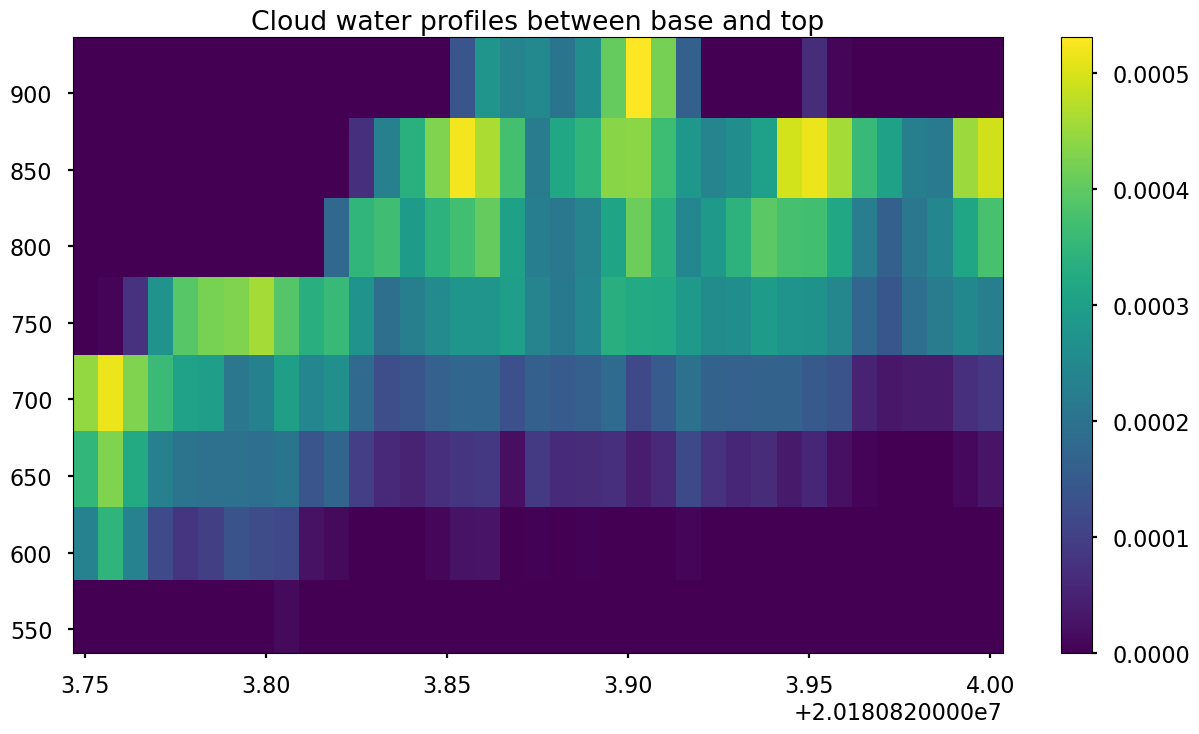

In [2]:
# CLoud mask and colorplot of LWC:

height_indices = np.where((np.min(cloudbases_icon)<heights) & (heights<950), [True]*len(ds_cb["height"]), [False]*len(ds_cb["height"]))
indices_dataarray = xr.DataArray(np.array(height_indices), dims="height", coords={"height":ds_cb["height"]})
ds_masked = ds_cb.where(indices_dataarray, drop=True)

###
# Plot colorplot:

plt.figure(figsize=(15,8))
plt.title("Cloud water profiles between base and top")
plt.pcolormesh(ds_masked["time"].values, ds_masked["z_mc"].values, ds_masked["qc"].values.T)
plt.colorbar()
plt.savefig(outputdir+"LWC_Colorplot_ICON")

print(ds_masked["time"])

any index timestep:  20180823.194444444
20180823.194444444


'\nplt.figure()\nplt.plot(ds_cb["qc"].values[np.argmax(h_icon),:], ds_cb["z_mc"].values, color="red", label="ICON")\n\n# Choose better timestep:\nplt.plot(ds_obs_lwc["lwc"].isel(time=12).values, ds_obs_lwc["height"], color="blue", label="Cloudnet")\n\nplt.ylim(0,1000)\nplt.savefig(outputdir+"LWC_0_bis_1000_ICON")\n\n###################################################\n# Why which Cloudnet timestep?\n\nprint(ds_obs_lwc["time"].values[5315])\n'

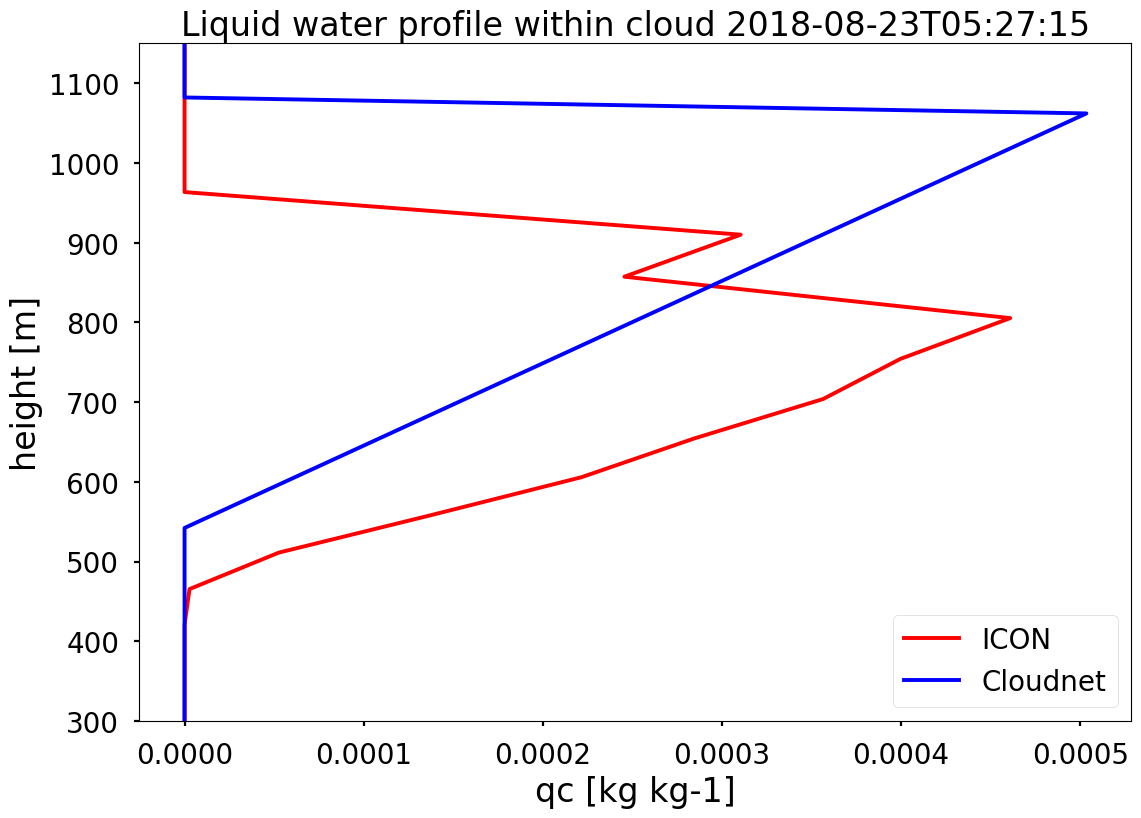

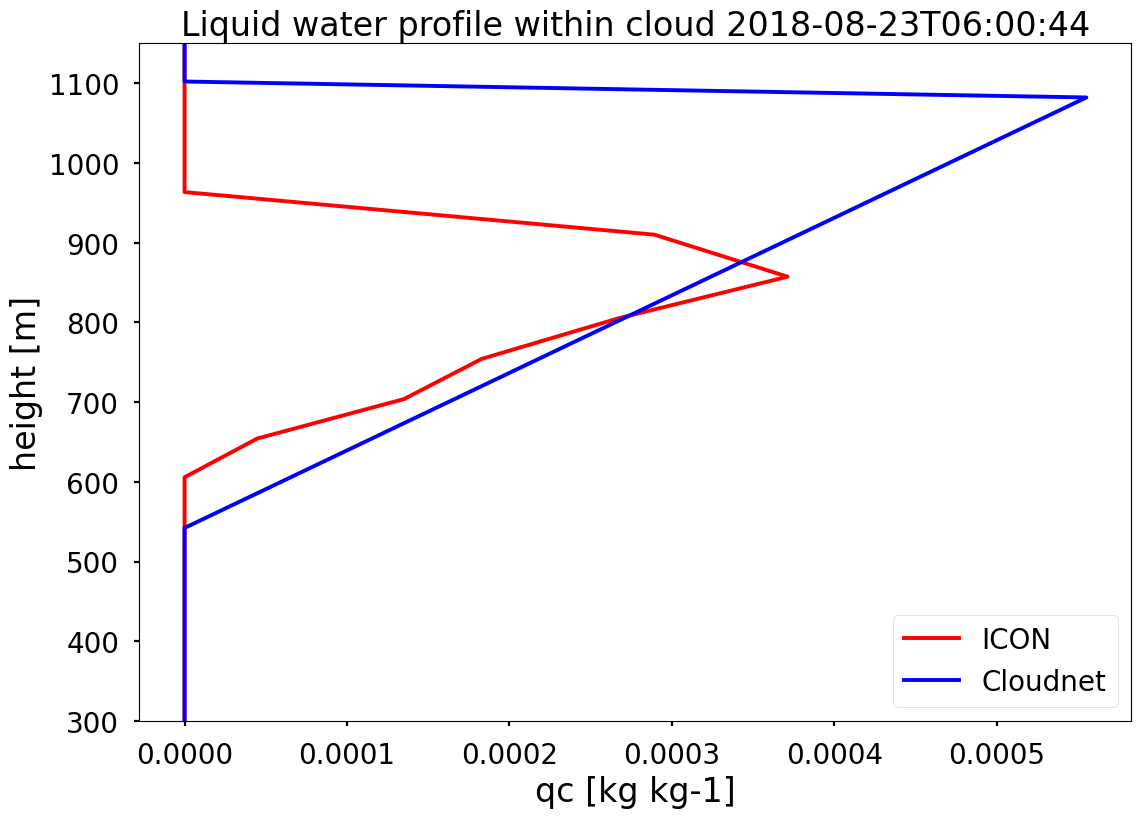

In [7]:
# Plot single profile:

'''
# Thickest cloud (15)
plt.figure(figsize=(10,10))
plt.title("Liquid water profile within cloud")
plt.plot(ds_masked["qc"].values[np.argmax(h_icon),:], ds_masked["z_mc"].values, color="red", label="ICON")
print("max index: ",np.argmax(h_icon))
print("max index timestep: ",ds_masked["time"].values[np.argmax(h_icon)])
# max index timestep:  20180823.854166668; denn: 5734*1.854166668/2 = 5315.895837156
plt.plot(ds_obs_lwc["lwc"].isel(time=5315).values, ds_obs_lwc["height"], color="blue", label="Cloudnet")
plt.ylim(0,1000)
plt.xlabel("qc ["+ds_cb["qc"].units+"]")
plt.ylabel("height [m]")
plt.legend()
plt.savefig(outputdir+"LWC_Thickest_cloud_ICON")

######################################

# Any other profile 1 (10):
plt.figure(figsize=(10,10))
plt.title("Liquid water profile within cloud")
plt.plot(ds_masked["qc"].values[10,:], ds_masked["z_mc"].values, color="red", label="ICON")
# Choose better timestep:
plt.plot(ds_obs_lwc["lwc"].isel(time=5203).values, ds_obs_lwc["height"], color="blue", label="Cloudnet")
plt.ylim(0,1000)
plt.xlabel("qc ["+ds_cb["qc"].units+"]")
plt.ylabel("height [m]")
plt.legend()
plt.savefig(outputdir+"LWC_any other profile1_ICON")
'''

#######################################

# Cloudnetmatch 1
plt.figure()#figsize=(10,10))
plt.title("Liquid water profile within cloud "+str(ds_obs_lwc["time"].values[3517])[:19], fontsize=24)
plt.plot(ds_icon["qc"].values[192,:], ds_icon["z_mc"].values, color="red", label="ICON")
plt.plot(ds_obs_lwc["lwc"].isel(time=3517).values, ds_obs_lwc["height"], color="blue", label="Cloudnet")
plt.ylim(300,1150)
plt.xlabel("qc ["+ds_cb["qc"].units+"]", fontsize=24)
plt.ylabel("height [m]", fontsize=24)
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig(outputdir+"LWC_ICON_vs_Cloudnet_profile1.png")

#######################################

# Cloudnetmatch 2
plt.figure()#figsize=(10,10))
plt.title("Liquid water profile within cloud "+str(ds_obs_lwc["time"].values[3584])[:19], fontsize=24)
plt.plot(ds_icon["qc"].values[196,:], ds_icon["z_mc"].values, color="red", label="ICON")

print("any index timestep: ",ds_icon["time"].values[196])
print(ds_icon["time"].values[196])
# Choose better timestep:
plt.plot(ds_obs_lwc["lwc"].isel(time=3584).values, ds_obs_lwc["height"], color="blue", label="Cloudnet")

plt.ylim(300,1150)
plt.xlabel("qc ["+ds_cb["qc"].units+"]", fontsize=24)
plt.ylabel("height [m]", fontsize=24)
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig(outputdir+"LWC_ICON_vs_Cloudnet_profile2.png")

######################################
'''
plt.figure()
plt.plot(ds_cb["qc"].values[np.argmax(h_icon),:], ds_cb["z_mc"].values, color="red", label="ICON")

# Choose better timestep:
plt.plot(ds_obs_lwc["lwc"].isel(time=12).values, ds_obs_lwc["height"], color="blue", label="Cloudnet")

plt.ylim(0,1000)
plt.savefig(outputdir+"LWC_0_bis_1000_ICON")

###################################################
# Why which Cloudnet timestep?

print(ds_obs_lwc["time"].values[5315])
'''

# print(ds_obs_lwc["height"].values)

In [4]:
# Mit welchem Gradienten vergleiche ich diese Profile? Klar wäre adiabatisch == linear.
# Aber was wäre die genaue Steigung des adiabatischen Flüssigwasserprofils?
# Wie lege ich fest, ob es sich hier um dieses Profil handelt oder um etwas anderes? Eine Hyperbel vielleicht?

5734*1.226837/2
# 313*1.25/2

3517.3416789999997

In [5]:
192/313*2

1.2268370607028753